In [0]:
#import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sklearn processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# Sklearn linear regression model
from sklearn.linear_model import LinearRegression

# Sklearn regression model evaluation functions
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

# Perform feature selection using a variance threshold
from sklearn.feature_selection import VarianceThreshold

# Feature selection using Recursive Feature Elimimation
from sklearn.feature_selection import RFE

In [2]:
#load the data and inspect the first 5 rows
dataset = pd.read_csv("bike.csv")
dataset.head()

,id,season,year,holiday,weekday,workingday,weather,temp,feel_temp,hum,windspeed,promotion_level,promotion_type,promotion_level_external,promotion_type_external,casual,registered,cnt
0,12765,winter,2016,0,6,0,cloud,0.344167,0.363625,0.805833,0.160446,7,1,2,2,226,654,880
1,12766,winter,2016,0,0,0,cloud,0.363478,0.353739,0.696087,0.248539,8,1,8,1,125,670,795
2,12767,winter,2016,0,1,1,fair,0.196364,0.189405,0.437273,0.248309,3,1,10,2,75,1229,1304
3,12768,winter,2016,0,2,1,fair,0.200000,0.212122,0.590435,0.160296,0,1,8,3,67,1454,1521
4,12769,winter,2016,0,3,1,fair,0.226957,0.229270,0.436957,0.186900,2,0,5,1,58,1518,1576


In [3]:
# Confirm the data types
dataset.dtypes

id                            int64
season                       object
year                          int64
holiday                       int64
weekday                       int64
workingday                    int64
weather                      object
temp                        float64
feel_temp                   float64
hum                         float64
windspeed                   float64
promotion_level               int64
promotion_type                int64
promotion_level_external      int64
promotion_type_external       int64
casual                        int64
registered                    int64
cnt                           int64
dtype: object

In [4]:
# Check for nulls
dataset.isnull().mean()

id                          0.0
season                      0.0
year                        0.0
holiday                     0.0
weekday                     0.0
workingday                  0.0
weather                     0.0
temp                        0.0
feel_temp                   0.0
hum                         0.0
windspeed                   0.0
promotion_level             0.0
promotion_type              0.0
promotion_level_external    0.0
promotion_type_external     0.0
casual                      0.0
registered                  0.0
cnt                         0.0
dtype: float64

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/misc.py:80: UserWarning: Attempting to set identical left == right == 2016.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/misc.py:81: UserWarning: Attempting to set identical bottom == top == 2016.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/misc.py:71: UserWarning: Attempting to set identical left == right == 2016.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


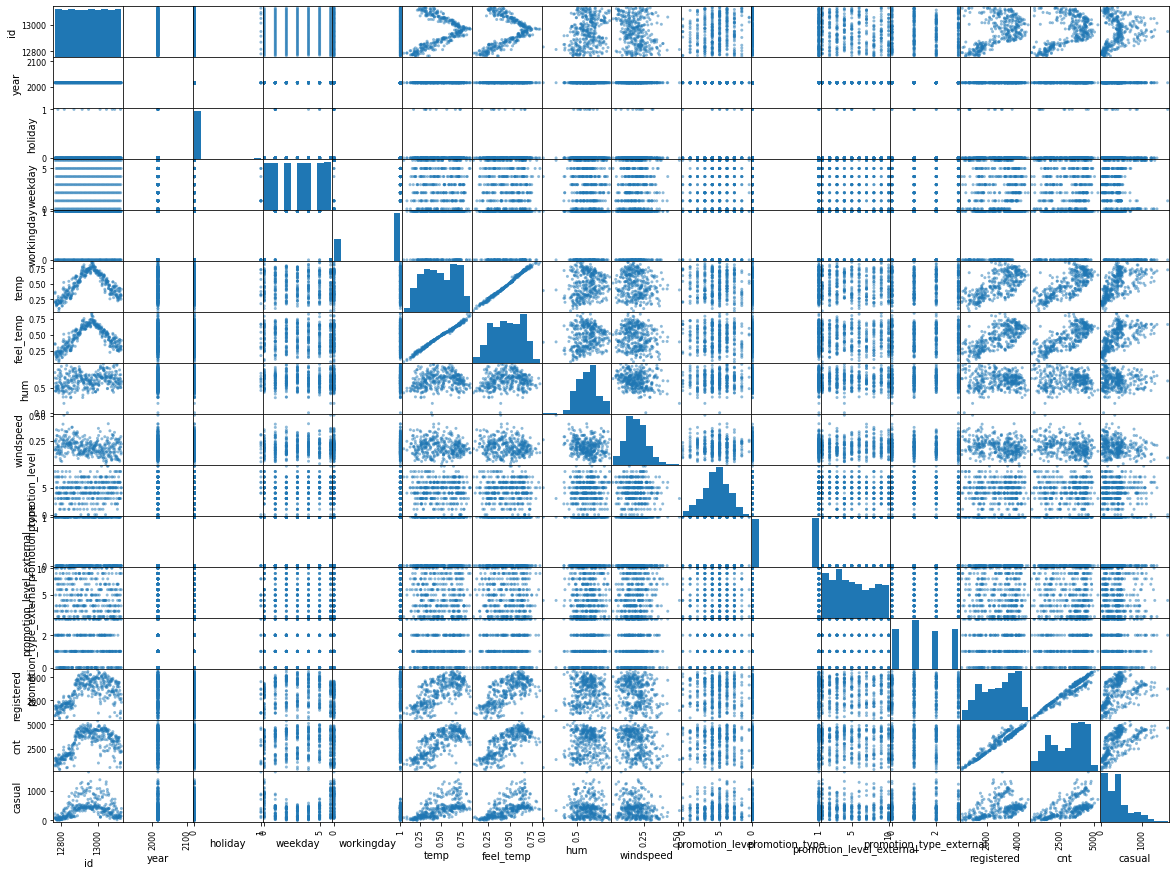

In [5]:
# Plot a scatter matrix
# I like to push the target feature to the bottom, so it is easy to read
df = dataset.drop('casual',axis=1).join(dataset.casual)
pd.plotting.scatter_matrix(df,figsize=(20,15))
plt.show()

 The two temperature columns, temp and feel_temp are unsurprisingly highly correlated. 
 We will probably want to remove one. 
 This is called Multicolinearity
 Also cnt and registered seem to be correlated.
 This is odd, as cnt is the total of casual + registered. 
 In fact, we should remove BOTH cnt and registered as they will cause "data leakage".


#FEATURE ENGINEERING

In [6]:
# Drop cnt and registered as they will cause data leakage
dataset = dataset.drop(['cnt','registered'], axis=1)

dataset = dataset.drop(['id'], axis=1)
dataset.head()

,season,year,holiday,weekday,workingday,weather,temp,feel_temp,hum,windspeed,promotion_level,promotion_type,promotion_level_external,promotion_type_external,casual
0,winter,2016,0,6,0,cloud,0.344167,0.363625,0.805833,0.160446,7,1,2,2,226
1,winter,2016,0,0,0,cloud,0.363478,0.353739,0.696087,0.248539,8,1,8,1,125
2,winter,2016,0,1,1,fair,0.196364,0.189405,0.437273,0.248309,3,1,10,2,75
3,winter,2016,0,2,1,fair,0.200000,0.212122,0.590435,0.160296,0,1,8,3,67
4,winter,2016,0,3,1,fair,0.226957,0.229270,0.436957,0.186900,2,0,5,1,58


In [7]:
dataset.shape

(365, 15)

In [8]:
# We have a few categorical columns, so we should one-hot-encode these to convert them to numerical columns.

categoricals = ['season','weekday','weather']
dataset = pd.get_dummies(dataset, columns=categoricals, drop_first=True)
dataset.head()

# Notice the column "season" has been broken into three columns "season_spring", "season_summer", "season_winter"
# and is one-hot encoded.

,year,holiday,workingday,temp,feel_temp,hum,windspeed,promotion_level,promotion_type,promotion_level_external,promotion_type_external,casual,season_spring,season_summer,season_winter,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_fair,weather_rain
0,2016,0,0,0.344167,0.363625,0.805833,0.160446,7,1,2,2,226,0,0,1,0,0,0,0,0,1,0,0
1,2016,0,0,0.363478,0.353739,0.696087,0.248539,8,1,8,1,125,0,0,1,0,0,0,0,0,0,0,0
2,2016,0,1,0.196364,0.189405,0.437273,0.248309,3,1,10,2,75,0,0,1,1,0,0,0,0,0,1,0
3,2016,0,1,0.200000,0.212122,0.590435,0.160296,0,1,8,3,67,0,0,1,0,1,0,0,0,0,1,0
4,2016,0,1,0.226957,0.229270,0.436957,0.186900,2,0,5,1,58,0,0,1,0,0,1,0,0,0,1,0


In [9]:
dataset.shape

(365, 23)

Notice the increase in the column features.

In [0]:
# Splitting into X and y

# Our target feature
y = dataset["casual"]  # df['casual'] and df.casual means the same.

# Our input features
X = dataset.drop(['casual'], axis=1) # axis = 1 specifies the drop along column dimension

In [0]:
# we can observe that our data is spread across wide differences of scale values.
# Rescale the input features
scaler = MinMaxScaler(feature_range=(0,1)) # all the features will now be in the range of [0, 1]
X_ = scaler.fit_transform(X)
X = pd.DataFrame(X_, columns=X.columns)

Notice the values, all the values are now between 0 and 1.

In [12]:
X.head()

,year,holiday,workingday,temp,feel_temp,hum,windspeed,promotion_level,promotion_type,promotion_level_external,promotion_type_external,season_spring,season_summer,season_winter,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_fair,weather_rain
0,0.0,0.0,0.0,0.360789,0.373517,0.828620,0.284606,0.777778,1.0,0.111111,0.666667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.385232,0.360541,0.715771,0.466215,0.888889,1.0,0.777778,0.333333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.173705,0.144830,0.449638,0.465740,0.333333,1.0,1.000000,0.666667,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.178308,0.174649,0.607131,0.284297,0.000000,1.0,0.777778,1.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.212429,0.197158,0.449313,0.339143,0.222222,0.0,0.444444,0.333333,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Simple Linear regression.

In [0]:
# split the data into (2/3) train and (1/3) test sets.
test_size = 0.33
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = seed)

Carefully observe the dataset shapes and the splitting ratio

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(244, 22)
(121, 22)
(244,)
(121,)


In [0]:
#custom functions
def score(model, X, y):
    """Get the model prediction scores using the provided input and target features"""
    
    predictions = model.predict(X)
    print("    R2", r2_score(y, predictions)) 


def linearRegressionSummary(model, column_names):
    '''Show a summary of the trained linear regression model'''

    # Plot the coeffients as bars
    fig = plt.figure(figsize=(8,len(column_names)/3))
    fig.suptitle('Linear Regression Coefficients', fontsize=16)
    rects = plt.barh(column_names, model.coef_,color="lightblue")

    # Annotate the bars with the coefficient values
    for rect in rects:
        width = round(rect.get_width(),4)
        plt.gca().annotate('  {}  '.format(width),
                    xy=(0, rect.get_y()),
                    xytext=(0,2),  
                    textcoords="offset points",  
                    ha='left' if width<0 else 'right', va='bottom')        
    plt.show()
    
def kFoldCV(X, y, silent=False):
    """Evaluate linear regression with k-fold cross validation"""
    
    model = LinearRegression()
    
    # Create folds
    seed = 2
    kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
    
    # Perform kfold cross validation
    results = cross_val_score(model, X, y, cv=kfold, scoring='r2')
    
    # Show results
    if not silent:
        print(type(model).__name__)
        print("kFoldCV:")
        print("    Fold R2 scores:", results)
        print("    Mean R2 score:", results.mean())
        print("    Std R2 score:", results.std())
    
    # Build a model using all the data and return it
    model.fit(X, y)

    return model

def correlatedFeatures(dataset, threshold):
    """Function to list features that are correlated
       Adds the first of the correlated pair only (not both)"""
    
    correlated_columns = set()
    correlations = dataset.corr()
    for i in range(len(correlations)):
        for j in range(i):
            if abs(correlations.iloc[i,j]) > threshold:
                correlated_columns.add(correlations.columns[i])
    return correlated_columns   

In [16]:
#build our model

model = LinearRegression()

#fit the model on the training data.
model.fit(X_train, y_train)
print("On training set : ") #score is our custom function for better visualization.
score(model, X_train, y_train)

On training set : 
    R2 0.798265855369959


In [17]:
#evaluate the model on the test set
print("On testing set")
score(model, X_test, y_test)


On testing set
    R2 0.7444590452036941


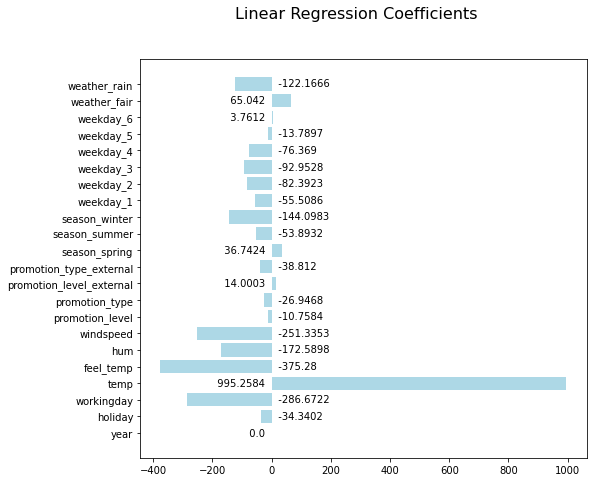

In [18]:
#summary 
linearRegressionSummary(model, X_train.columns) #this is also a custom function

Resampling with k-fold cross-validation

LinearRegression
kFoldCV:
    Fold R2 scores: [0.70089783 0.75747131 0.76457769 0.57715067 0.81138158 0.76913595
 0.84251758 0.74793549 0.78256577 0.7103859 ]
    Mean R2 score: 0.7464019778462545
    Std R2 score: 0.06910444190350555
On test set : 
    R2 0.7444590452036941


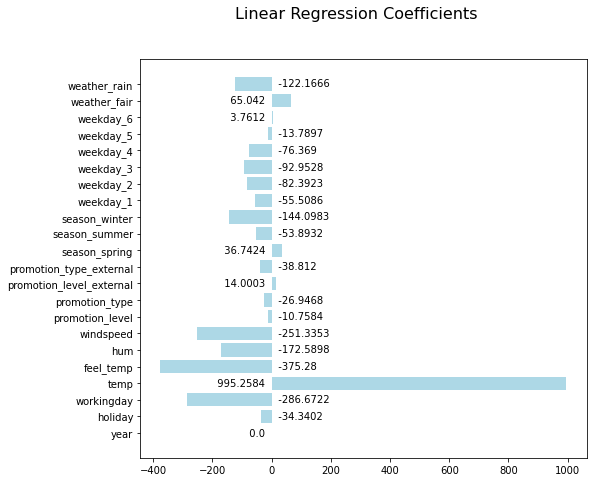

In [19]:
#evaluate the model with k = 10 fold cross validation
model = kFoldCV(X_train, y_train)
print("On test set : ")
score(model,  X_test, y_test)

linearRegressionSummary(model, X_train.columns)

 r-squared values are pretty consistent. We can be more confident due to the evaluation against 10 fold sets.

# Feature Selection

In [20]:
#remove the low variance features
#check the shape before removing.
X_test.shape


(121, 22)

In [21]:
X.var()

year                        0.000000
holiday                     0.026720
workingday                  0.216393
temp                        0.057592
feel_temp                   0.049115
hum                         0.023394
windspeed                   0.025126
promotion_level             0.044400
promotion_type              0.250685
promotion_level_external    0.104256
promotion_type_external     0.134599
season_spring               0.189041
season_summer               0.189041
season_winter               0.186286
weekday_1                   0.122505
weekday_2                   0.122505
weekday_3                   0.122505
weekday_4                   0.122505
weekday_5                   0.122505
weekday_6                   0.124462
weather_fair                0.236444
weather_rain                0.039515
dtype: float64

In [22]:
# remove low variance features using Variance Threshold.

sel = VarianceThreshold(threshold = (0.01))
sel.fit(X_train)

selected_features = list(X_train.columns[sel.get_support()])
print("Feature Selection : ", sel.get_support())
print("Selected features : ", selected_features)
print("Removed features : ", list(X_train.columns[~sel.get_support()]))

Feature Selection :  [False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]
Selected features :  ['holiday', 'workingday', 'temp', 'feel_temp', 'hum', 'windspeed', 'promotion_level', 'promotion_type', 'promotion_level_external', 'promotion_type_external', 'season_spring', 'season_summer', 'season_winter', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weather_fair', 'weather_rain']
Removed features :  ['year']


Year is removed obviously because it has 0 variance.

In [0]:
#transform / remove the low variance features
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

In [24]:
X_train.shape

(244, 21)

In [0]:
#turn back into a dataframe
X_train = pd.DataFrame(X_train, columns = selected_features)
X_test = pd.DataFrame(X_test, columns = selected_features)

In [26]:
#confirm the new shape
X_train.shape

(244, 21)

Correlated features

In [27]:
cf = correlatedFeatures(X_train, 0.85) #custom function.
cf

{'feel_temp'}

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


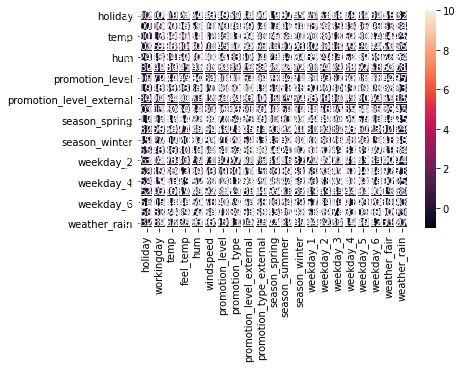

In [28]:
import seaborn as sns

sns.heatmap(X_train.corr(), annot = True, linewidths = 0.9, vmin = -1, vmax = 10, fmt = 'f')


In [0]:
#remove the correlated features
X_train = X_train.drop(cf, axis = 1)
X_test = X_test.drop(cf, axis = 1)

In [30]:
#confirm the new shape
X_train.shape

(244, 20)

Recursive Feature Elimination (RFE)

In [31]:
# Build models using from 1 to n-1 features
for i in range(1,X_train.shape[1]-1):
    print("\nRFE ", i, end="\t")
    # Create a model
    model = LinearRegression()

    # Select the best features according to RFE
    rfe = RFE(model, i)
    rfe.fit(X_train, y_train)

    # Transform (remove features not selected)
    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)

    # Evaluate using k-fold cross-validation
    model = kFoldCV(X_train_rfe, y_train, silent=True)
    predictions = model.predict(X_test_rfe)
    print("R2", r2_score(y_test, predictions)) 


RFE  1	R2 0.02888623396301704

RFE  2	R2 0.04543862170332247

RFE  3	R2 0.07543442440711368

RFE  4	R2 0.10296400954742568

RFE  5	R2 0.272698283971302

RFE  6	R2 0.3006683600463339

RFE  7	R2 0.3008150122127332

RFE  8	R2 0.70744213402598

RFE  9	R2 0.714025216913988

RFE  10	R2 0.7344648524102104

RFE  11	R2 0.7533773976390342

RFE  12	R2 0.7515769246145185

RFE  13	R2 0.7623304366150094

RFE  14	R2 0.7587323610669645

RFE  15	R2 0.7574317996593046

RFE  16	R2 0.754820733630902

RFE  17	R2 0.7444196795294524

RFE  18	R2 0.7427100535744618


The best value of RFE corresponds to 15 features, so let's keep 15 best features

In [32]:
#now we again create a model with the 15 best features.
model = LinearRegression()

#select the best 15 features according to RFE
rfe = RFE(model, 15)
rfe.fit(X_train, y_train)

selected_features = list(X_train.columns[rfe.support_])
print("Feature selection : ", rfe.support_)
print("Feature ranking : ", rfe.ranking_)
print("Selected features : ", selected_features)
print("Removed features : ", list(X_train.columns[~rfe.support_]))

Feature selection :  [ True  True  True  True  True False False False False  True  True  True
  True  True  True  True  True False  True  True]
Feature ranking :  [1 1 1 1 1 5 3 4 2 1 1 1 1 1 1 1 1 6 1 1]
Selected features :  ['holiday', 'workingday', 'temp', 'hum', 'windspeed', 'season_spring', 'season_summer', 'season_winter', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weather_fair', 'weather_rain']
Removed features :  ['promotion_level', 'promotion_type', 'promotion_level_external', 'promotion_type_external', 'weekday_6']


In [33]:
#original datashape before applying RFE
X_train.shape

(244, 20)

In [0]:
#transform/remove the features not selected
X_train = rfe.transform(X_train)
X_test = rfe.transform(X_test)

In [35]:
#datashape after applying RFE and selecting 15 best features.
X_train.shape

(244, 15)

## Evaluate a model with the features removed
Now that we have removed a number of features using low-variance removal, highly correlated feature removal and RFE, build and evaluate a linear regression model with this reduced feature set.

LinearRegression
kFoldCV:
    Fold R2 scores: [0.77971263 0.75494178 0.75360017 0.59241516 0.82542326 0.76481585
 0.82983648 0.7516577  0.77767125 0.74226025]
    Mean R2 score: 0.7572334530725484
    Std R2 score: 0.06191960018874785
On test set : 
    R2 0.7574317996593046


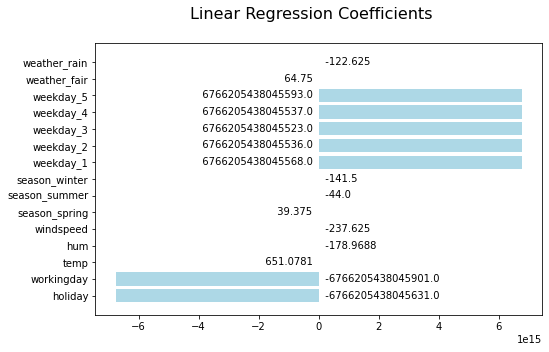

In [36]:
#again build a model with the removed feature set ( containing 15 best features by RFE )

model = kFoldCV(X_train, y_train) #custom function
print("On test set : ")
score(model, X_test, y_test)
linearRegressionSummary(model, selected_features)

So, we've managed to improve the R-squared score and removed a number of features, making the model faster and easier to interpret. We've also used cross-validation to give us confidence that the model will perform consistently.

Using cross-validation version of RFE to determine the number of features to keep

Optimal number of features :  15


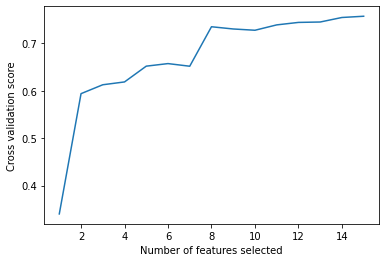

In [37]:
from sklearn.feature_selection import RFECV

model = LinearRegression()
seed = 2
kfold = KFold(n_splits = 10, shuffle = True, random_state = seed)
rfecv = RFECV(estimator = model, step = 1, cv = kfold, scoring = 'r2')
rfecv.fit(X_train, y_train)

print("Optimal number of features : ", rfecv.n_features_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

#Lasso Regression : Regularization

In [47]:
from sklearn.linear_model import Lasso

test_size = 0.33
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = seed)

#hyper-parameter : alpha
alpha = 1.0

#create the model
model = Lasso(alpha = alpha)

#fit the model
model.fit(X_train, y_train)
predictions = model.predict(X_train)
print("On train set : ", r2_score(y_train, predictions))

#evaluate
predictions = model.predict(X_test)
print("On test set : ", r2_score(y_test, predictions))


On train set :  0.7926483949392624
On test set :  0.7293428960865496


#Lasso regression with k-fold cross validation

In [43]:
from sklearn.linear_model import LassoCV

test_size = 0.33
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = seed )

kfold = KFold(n_splits = 10, shuffle = True, random_state = seed)

#create the model
model = LassoCV(cv = kfold)

#fit the model
model.fit(X_train, y_train)
predictions = model.predict(X_train)
print("On train set : ", r2_score(y_train, predictions))

#evaluate
predictions = model.predict(X_test)
print("On test set : ", r2_score(y_test, predictions))

#model coefficients
print("alpha : ", model.alpha_)

On train set :  0.7874738378569627
On test set :  0.7229970663700086
alpha :  1.9382689779472455


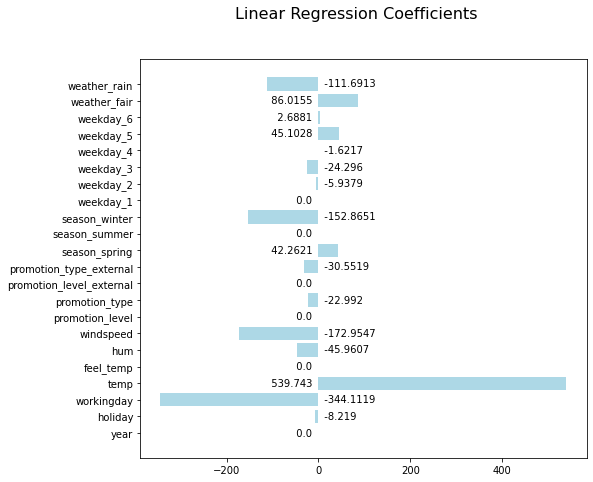

In [48]:
linearRegressionSummary(model, X_train.columns)

We can see that Lasso regression has automatically done a lot of feature selection. The collinear feel_temp has a zero coefficient. 
It has been effectively removed.
The model is much more interpretable than the baseline linear regression model.

Hence, Lasso regression has embedded Feature Selection.

#Ridge regression




In [49]:
from sklearn.linear_model import Ridge

test_size = 0.33
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = seed)

#hyper-parameter : alpha
alpha = 1.0

#create the model
model = Ridge(alpha = alpha)

#fit the model
model.fit(X_train, y_train)
predictions = model.predict(X_train)
print("On train set : ", r2_score(y_train, predictions))

#evaluate
predictions = model.predict(X_test)
print("On test set : ", r2_score(y_test, predictions))


On train set :  0.7946530629928134
On test set :  0.7304628682487391


#Ridge regression with k-fold cross validation

In [54]:
from sklearn.linear_model import RidgeCV

test_size = 0.33
seed = 7

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = seed)

kfold = KFold(n_splits = 10, shuffle = True, random_state = seed)

#create the model
model = RidgeCV(cv = kfold)

#fit the model
model.fit(X_train, y_train)
predictions = model.predict(X_train)
print("On train set : ", r2_score(y_train, predictions))

#evaluate
predictions = model.predict(X_test)
print("On train set : ", r2_score(y_test, predictions))



On train set :  0.7946530629928134
On train set :  0.7304628682487391


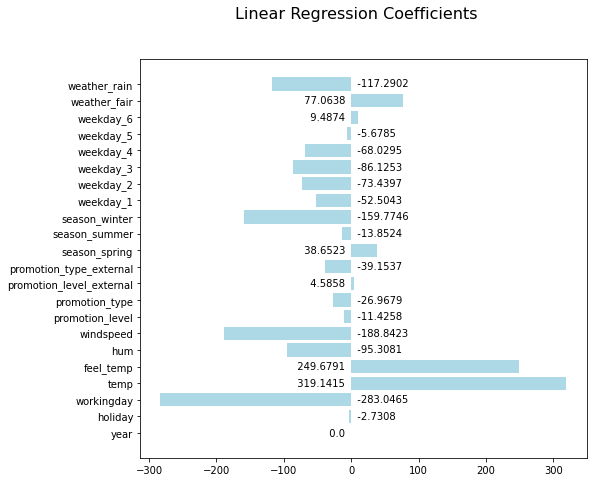

In [55]:
linearRegressionSummary(model, X_train.columns)

Only year has a coefficient of 0 that too because it has 0 variance.
Rest all the features are kept as it is.
Hence, Ridge regression doesn't drive smaller coefficients to 0 hence it doesn't possess internal feature selection.